numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录

In [39]:
#导入需要的包
!python -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import paddle
print("Paddle版本号为："+paddle.__version__)
!python -m pip install visualdl -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
You should consider upgrading via the '/Users/vincent/.pyenv/versions/3.6.3/envs/torch_3.6.3/bin/python -m pip install --upgrade pip' command.
Paddle版本号为：2.1.3
Looking in indexes: https://mirror.baidu.com/pypi/simple
You should consider upgrading via the '/Users/vincent/.pyenv/versions/3.6.3/envs/torch_3.6.3/bin/python -m pip install --upgrade pip' command.


# （一）准备数据

(1)数据集介绍

MNIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)transform函数是定义了一个归一化标准化的标准

(3)train_dataset和test_dataset

paddle.vision.datasets.MNIST()中的mode='train'和mode='test'分别用于获取mnist训练集和测试集

transform=transform参数则为归一化标准

In [40]:
#导入数据集Compose的作用是将用于数据集预处理的接口以列表的方式进行组合。
#导入数据集Normalize的作用是图像归一化处理，支持两种方式： 1. 用统一的均值和标准差值对图像的每个通道进行归一化处理； 2. 对每个通道指定不同的均值和标准差值进行归一化处理。
from paddle.vision.transforms import Compose, Normalize, Resize, RandomRotation, RandomCrop
img_size = 32
#对训练集做数据增强
transform1 = Compose([Resize((img_size+2, img_size+2)), RandomCrop(img_size), Normalize(mean=[127.5],std=[127.5],data_format='CHW')])
transform2 = Compose([Resize((img_size, img_size)), Normalize(mean=[127.5],std=[127.5],data_format='CHW')])
# 使用transform对数据集做归一化
print('下载并加载训练数据')
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=transform1)
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=transform2)
print('加载完成')

下载并加载训练数据
加载完成


图片：
<class 'numpy.ndarray'>
[[[-1.        -1.        -1.        ... -1.        -1.        -1.       ]
  [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
  [-1.        -1.        -1.        ... -1.        -1.        -1.       ]
  ...
  [-1.        -1.        -0.8039216 ... -1.        -1.        -1.       ]
  [-1.        -1.        -0.9137255 ... -1.        -1.        -1.       ]
  [-1.        -1.        -1.        ... -1.        -1.        -1.       ]]]
标签：
<class 'numpy.ndarray'>
[5]


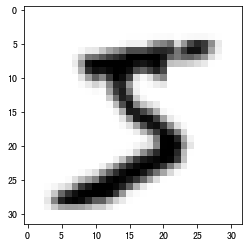

In [41]:
#数据集查看
print('图片：')
print(type(train_dataset[0][0]))
print(train_dataset[0][0])
print('标签：')
print(type(train_dataset[0][1]))
print(train_dataset[0][1])

# 可视化展示
plt.figure()
plt.imshow(train_dataset[0][0].reshape([32,32]), cmap=plt.cm.binary)  #图片大小为 [32,32]
plt.show()

# （二）搭建网络
```
**任务一：搭建自己的神经网络MyNet()**
```

In [42]:
import paddle
import paddle.nn.functional as F
# 定义多层卷积神经网络
#动态图定义多层卷积神经网络
class MyNet(paddle.nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(1, 10, kernel_size=5)
        self.conv2 = paddle.nn.Conv2D(10, 20, kernel_size=5)
        self.conv2_drop = paddle.nn.Dropout2D()
        self.fc1 = paddle.nn.Linear(500, 256)
        self.fc2 = paddle.nn.Linear(256, 10)

        
        
    def forward(self, x):
        x = paddle.nn.functional.relu(paddle.nn.functional.max_pool2d(self.conv1(x),2))
        x = paddle.nn.functional.relu(paddle.nn.functional.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        x = paddle.reshape(x,[-1,500])
        x = paddle.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        y = paddle.nn.functional.log_softmax(x)
        # print(y)
        return y


#模型网络结构可视化
net_cls = MyNet()
paddle.summary(net_cls, (-1, 1, img_size, img_size))

---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Conv2D-9       [[1, 1, 32, 32]]     [1, 10, 28, 28]          260      
   Conv2D-10     [[1, 10, 14, 14]]     [1, 20, 10, 10]         5,020     
  Dropout2D-5    [[1, 20, 10, 10]]     [1, 20, 10, 10]           0       
   Linear-9          [[1, 500]]            [1, 256]           128,256    
   Linear-10         [[1, 256]]            [1, 10]             2,570     
Total params: 136,106
Trainable params: 136,106
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.52
Estimated Total Size (MB): 0.62
---------------------------------------------------------------------------



{'total_params': 136106, 'trainable_params': 136106}

# （三）参数设置及模型训练

In [43]:
from paddle.metric import Accuracy


#可自行调试参数
patience = 5
epoch = 50
lr = 0.01
weight_decay = 5e-4
batch_size = 64
momentum = 0.9


In [44]:
# 用Model封装模型

model = paddle.Model(net_cls)

save_dir = "output/model/Momentum"  #使用不同的优化方法的模型参数保存到不同的文件夹中

# 定义优化方法
optim_Mom = paddle.optimizer.Momentum(learning_rate=lr, parameters=model.parameters(), momentum=momentum)

# sgd:
# optim_SGD = paddle.optimizer.SGD(learning_rate=lr, parameters = model.parameters())

# adm:
# optim_Adam = paddle.optimizer.Adam(learning_rate=lr, parameters=model.parameters())

# Adagrad:
# optim_Adagrad = paddle.optimizer.Adagrad(learning_rate=lr, parameters=model.parameters())

# RMS
# optim_RMS = paddle.optimizer.RMSProp(learning_rate=lr, parameters=model.parameters(), weight_decay=0.01)

# 都跑一遍，然后截图：

# 配置模型
model.prepare(optim_Mom,paddle.nn.CrossEntropyLoss(),Accuracy())

# 训练保存并验证模型

# callback机制结合VDL
path = './res/train/visualdl_log_dir'
if not os.path.exists(path):
    os.makedirs(path)
callback_train = paddle.callbacks.VisualDL(log_dir='./res/train/visualdl_log_dir')

#此处用的是model.fit（）方法训练，同学们也可以选择自己定义train（）、eval（）方法
model.fit(train_dataset,test_dataset,epochs=epoch,batch_size=batch_size, callbacks=callback_train)

# model.save('checkpoint/test')  # save for training
model.save(save_dir)  # save for inference



The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/50
step  10/938 - loss: 2.2470 - acc: 0.1562 - 30ms/step
step  20/938 - loss: 1.5252 - acc: 0.2469 - 28ms/step
step  30/938 - loss: 1.2694 - acc: 0.3339 - 27ms/step
step  40/938 - loss: 0.9544 - acc: 0.4113 - 26ms/step
step  50/938 - loss: 1.2464 - acc: 0.4616 - 28ms/step
step  60/938 - loss: 0.7025 - acc: 0.5096 - 28ms/step
step  70/938 - loss: 0.8854 - acc: 0.5458 - 28ms/step
step  80/938 - loss: 0.7325 - acc: 0.5746 - 27ms/step
step  90/938 - loss: 0.5605 - acc: 0.6010 - 26ms/step
step 100/938 - loss: 0.4137 - acc: 0.6225 - 26ms/step
step 110/938 - loss: 0.5773 - acc: 0.6401 - 26ms/step
step 120/938 - loss: 0.5112 - acc: 0.6553 - 25ms/step
step 130/938 - loss: 0.6475 - acc: 0.6691 - 25ms/step
step 140/938 - loss: 0.5149 - acc: 0.6818 - 26ms/step
step 150/938 - loss: 0.6922 - acc: 0.6947 - 26ms/step
step 160/938 - loss: 0.4678 - acc: 0.7039 - 27ms/step
step 170/938 - 


```
任务二：
测试不同的优化方法，包括SGD/Momentum/Adam/Adagrad/Rmsprop，画出验证集test_dataset的acc和loss曲线。可视化方法VisualDL可做参考：[https://aistudio.baidu.com/aistudio/projectdetail/1230514?channelType=0&channel=0]
```

In [45]:
#任务二：此处展示不同优化方法下验证集test_dataset的acc和loss曲线

# 具体不同的优化方法所对应的曲线截图放到README中 #

# callback机制结合VDL
# callback_test = paddle.callbacks.VisualDL(log_dir='./res/test/visualdl_log_dir')
model.evaluate(test_dataset, verbose=1) # batch_size=64,





Eval begin...
step 10000/10000 [==============================] - loss: 1.7881e-06 - acc: 0.9929 - 3ms/step          
Eval samples: 10000


{'loss': [1.7881409e-06], 'acc': 0.9929}

* Momentum : {'loss': [1.7881409e-06], 'acc': 0.9929}
* SGD :{'loss': [4.4585267e-05], 'acc': 0.966}
* Adam :{'loss': [0.00010455201], 'acc': 0.9781}
* Adagrad :{'loss': [8.344685e-06], 'acc': 0.9912}
* RMS :{'loss': [0.00064697926], 'acc': 0.9624}

# （四）模型验证及测试

In [51]:
#用最好的模型在测试集10000张图片上验证

best_model_path = "work/best_model.pdparams"  
net_cls = MyNet()
model = paddle.Model(net_cls)
model.load(best_model_path)
model.prepare(optim_Mom,paddle.nn.CrossEntropyLoss(),Accuracy())

In [52]:
results = model.evaluate(test_dataset, batch_size=batch_size, verbose=1)
print(results)

Eval begin...
step 157/157 [==============================] - loss: 1.3385e-04 - acc: 0.9929 - 12ms/step      
Eval samples: 10000
{'loss': [0.00013385224], 'acc': 0.9929}


AxesImage(18,18;111.6x108.72)
test_data0 的标签为: [7]
Predict begin...
step 10000/10000 [==============================] - 3ms/step          
Predict samples: 10000
test_data0 预测的数值为：7


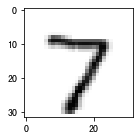

In [53]:
########测试
#获取验证集的第一个图片

test_data0, test_label_0 = test_dataset[0][0],test_dataset[0][1]
test_data0 = test_data0.reshape([img_size,img_size])
plt.figure(figsize=(2,2))
#展示验证集中的第一个图片
print(plt.imshow(test_data0, cmap=plt.cm.binary))
print('test_data0 的标签为: ' + str(test_label_0))
#模型预测
result = model.predict(test_dataset, batch_size=1)
#打印模型预测的结果
print('test_data0 预测的数值为：%d' % np.argsort(result[0][0])[0][-1])